<a href="https://colab.research.google.com/github/zahnmunch/GIT713-2022-academic/blob/master/Python_wrangle_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From Tidyverse to Pandas and Back – An Introduction to Data Wrangling with Pyhton and R - [link text](https://thatdatatho.com/from-tidyverse-to-pandas-and-back-an-introduction-to-data-wrangling-with-pyhton-and-r/)

In [ ]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=ac625bd18051d8268338606e26653ed9c9ee86bb8bcdff31bc5a4c4097a54b44
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
from adjustText import adjust_text
from mizani.formatters import dollar_format

In [ ]:
# read in data 
collist = ["name", "type", "degree_length", "in_state_tuition"]
cost = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_cost.csv", usecols=collist, encoding = "ISO-8859-1") 
income = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_income.csv")

In [ ]:
cost.head()

,name,type,degree_length,in_state_tuition
0,Aaniiih Nakoda College,Public,2 Year,2380
1,Abilene Christian University,Private,4 Year,34850
2,Abraham Baldwin Agricultural College,Public,2 Year,4128
3,Academy College,For Profit,2 Year,17661
4,Academy of Art University,For Profit,4 Year,27810


We are interested in which college has consistently increased tuition prices over the past years. 

We must drop net_cost and income_lvl, group by name and year, and then calculate the mean for each university in each year.

We are using filter() to drop columns and group_by() + agg() for calculating the mean. In order to avoid multilevel indexing, we have to reset the index and then also rename the total_price column to avg_per_year.

In [ ]:
temp_py = (income.filter(["name", "total_price", "year"])
    # group by year and name to aggregate multiple rows with same year and name
    .groupby(["name", "year"]) # or as_index = False
    .agg({"total_price": "mean"})
    .reset_index()
    .sort_values(["name", "year"])
    .rename(columns = {"total_price": "avg_per_year"}))

Another way to accomplish this would be to use the assign() method in combination with groupby() + transform(). This way, we are adding a new column, avg_per_year. One thing to note is that the transform() method works similarly to the mutate() function in R and the number of rows is equal to the original data frame. Hence, we are dropping duplicate rows and then also dropping the total_price column afterward in the code below.

In [ ]:
temp_py = (income.filter(["name", "total_price", "year"])
    # group by year and name to aggregate multiple rows with same year and name
    .assign(avg_per_year = lambda x: x.groupby(["name", "year"])["total_price"] 
    .transform(lambda x: x.mean())) 
    .drop("total_price", axis = 1)
    .drop_duplicates()
    .sort_values(["name", "year"]))

– For Python, we can use the the transform method with np.diff to calculate the difference and in R we are using the base function diff.

In [ ]:
# calculate the difference for each year in college tuition
temp_py = (temp_py.assign(count = lambda x: x.groupby("name")["name"].transform("count"),
    difference = lambda x: x.groupby("name")["avg_per_year"].transform(lambda x: np.append(np.nan, np.diff(x)))) \
    # filter out tuition where there has not been an increase in tuition each year
    .query("(difference >= 0) or difference != difference") \
    .assign(count_2 = lambda x: x.groupby("name")["name"].transform("count")) \
    # throw out rows where there has not been a consistent increase intuition over the years
    .query("(count_2 == count)"))

In [ ]:
# inner join to get degree length and type of university
tuition_income = pd.merge(temp_py,
                          cost,
                          on = "name")
temp_py_2 = (tuition_income.query('degree_length == "4 Year"') \
    .assign(change_in_price = lambda x: x.groupby('name')['avg_per_year'] \
    .transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])))

In [ ]:
diff_types = np.unique(tuition_income["type"])
# initializing empty data frame
df = pd.DataFrame(columns = tuition_income.columns)
for i in range(len(diff_types)):
    tu_in = (temp_py_2.groupby("type") \
        .get_group(diff_types[i]) \
        .sort_values("change_in_price", ascending = False))
    top_3 = tu_in.drop_duplicates("name")["name"][0:3].reset_index()
    tu_in = (tu_in[tu_in["name"].isin(top_3['name'])] \
        .sort_values(["name", "year"]))
    df = df.append(tu_in)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


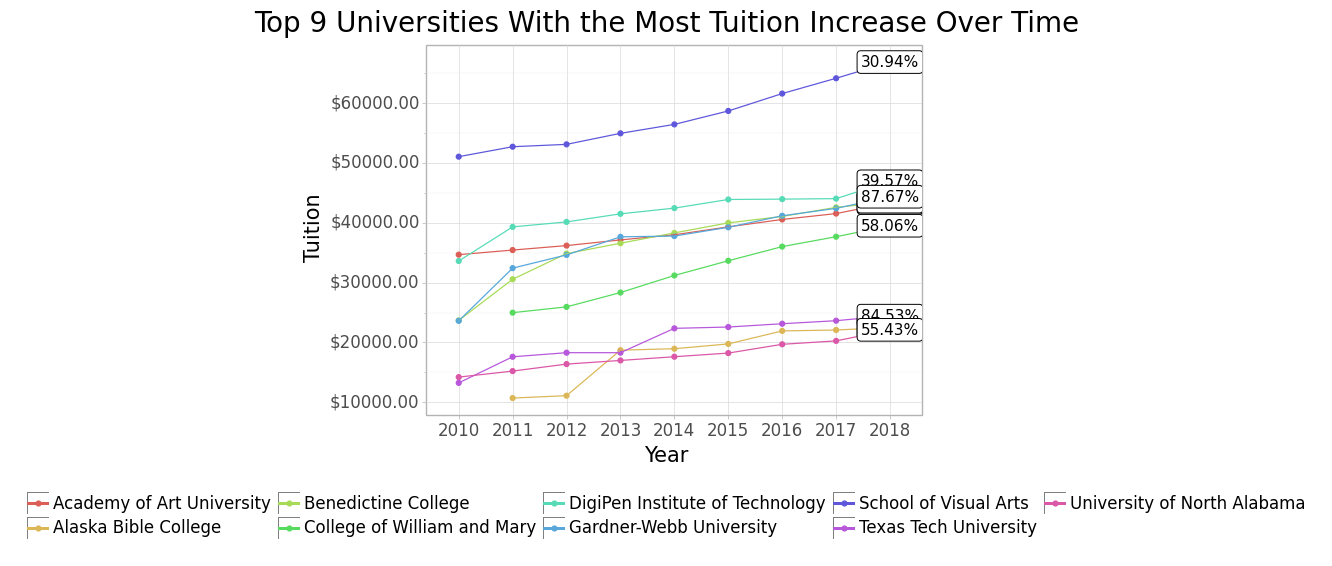

<ggplot: (8782108694821)>

In [ ]:
df_text = df.sort_values(["name", "type", "year"], ascending = False) \
    .drop_duplicates("name") \
    .assign(change_in_price = lambda x: round(x["change_in_price"] * 100, 2))

(ggplot(df, aes(x = "factor(year)", y = "avg_per_year", color = "factor(name)", group = "name")) +
    geom_point() +
    geom_line() +
    geom_label(data = df_text, mapping = aes(x = "factor(year)", y = "avg_per_year",
    label = "change_in_price"), color = "black",
    format_string='{}%') +
    theme_light() +
    theme(legend_position = (.5, -.1),
          legend_direction = 'horizontal',
          plot_title = element_text(hjust = 0.5, size = 20),
          legend_title = element_blank(),
          axis_title = element_text(size = 15),
          axis_text = element_text(size = 12),
          legend_text = element_text(size = 12)) +
          scale_y_continuous(labels = dollar_format()) +
     ylab("Tuition") +
     xlab("Year") +
     ggtitle("Top 9 Universities With the Most Tuition Increase Over Time"))